In [1]:
# -*- Encoding: Latin-1 -*-
#!/usr/bin/python

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [7]:
# Autoencoder constructor

class AutoEncoder(nn.Module) :
    def __init__(self, n_lambda, n_endmembers, width_list, lr):
        super().__init__()

        # Encoder : y=(Pixel, Spectrum of the pixel) -> a(pixel,endmember)=(Pixel, Abundances of the endmembers mean / variance)
        layers = []
        input_width = n_lambda
        for output_width in width_list:
            layers.append(nn.Linear(input_width, output_width))
            layers.append(nn.ReLU())
            input_width = output_width 
        self.encoder = nn.Sequential(*layers)

        self.gaussian_mean = nn.Linear(width_list[-1], n_endmembers)
        self.gaussian_std = nn.Linear(width_list[-1], n_endmembers)
        
        # Decoder : a(pixel,endmember)=(Pixel, Abundances of the endmembers mean / variance) -> y_pred=(Pixel, Generated Spectrum of the pixel)
        self.decoder = nn.Linear(n_endmembers, n_lambda)
        
        self.optimizer = optim.Adam(params=self.parameters(), lr=lr)
        self.loss_function = nn.MSELoss()

    def encode(self, x):
        z = self.encoder(x)
        mean = self.gaussian_mean(z)
        log_var = self.gaussian_std(z)
        return mean, log_var

    def reparametrize(self,mean,log_var):
        noise = torch.randn_like(mean)
        std = torch.exp(0.5*log_var)
        x_embed = mean + std*noise
        x_embed_constrained = SumToOne(x_embed)
        return x_embed_constrained

    def decode(self, x_embed):
        return self.decoder(x_embed)

    def forward(self,x):
        mean, log_var = self.encode(x)
        x_embed = self.reparametrize(mean, log_var)
        pred = self.decoder(x_embed)
        return pred, mean, log_var

    def training_step(self, train_data_batch, valid_data_batch, beta):

        # Training Loss
        pred, mean, log_var = self.forward(train_data_batch)
        recon_loss = self.loss_function(pred, train_data_batch)
        kl_div = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
        training_loss = recon_loss + beta * kl_div

        # Validation Loss
        pred, mean, log_var = self.forward(valid_data_batch)
        recon_loss = self.loss_function(pred, valid_data_batch)
        kl_div = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
        validation_loss = recon_loss + beta * kl_div

        self.optimizer.zero_grad()
        training_loss.backward()
        self.optimizer.step()
        return training_loss.item(), validation_loss.item()  
    
def SumToOne(x, eps = 1e-8):
    x = torch.where(x<=eps, torch.zeros_like(x), x)
    x = x/(torch.sum(x)+eps)
    return x


In [8]:
# ------------------------------------------------------------------------------
# Hyperspectral Image (HSI) data
# ------------------------------------------------------------------------------ 
 
        
class HSI:

    """
    Class used to represent Hyperspectral Image (HSI) data
    
    Parameters
    ----------
    
    data: numpy array
      spectral observations
    rows: int
      number of rows in the image
    cols: int
      number of columns in the image
    
    Attributes
    ----------
    
    data: numpy array 
      spectral observations
    rows: int
      number of rows in the image
    cols: int
      number of columns in the image
    bands: int
      number of spectral bands
    image: array-like  
      hyperspectral image
    gt: numpy array
      endmembers
    abundances_map: numpy array
      abundances map
    """
    
    def __init__(self, data, rows, cols, endmembers, abundances_map):
    
        if data.shape[0] < data.shape[1]:
            data = data.transpose()
            
        self.bands = data.shape[1]
        self.cols = cols
        self.rows = rows
        self.image = np.reshape(data,(self.rows, self.cols, self.bands))
       
        self.endmembers = endmembers
        self.abundances_map = abundances_map
        
        
    def get_spectra(self):
    
        """
        Returns the spectral observations
        
        Returns
        -------
        
        out: numpy array
          spectral observations
        """
    
        return np.reshape(self.image, (self.rows*self.cols, self.bands))
        
        
    def get_abundances(self):
    
        """
        Return the abundances associated with the spectral observations
        
        Return
        ------
        
        out: numpy array (size: n by k)
          abundances
        """
        return np.reshape(self.abundances_map, (self.rows*self.cols, -1))
    
    def get_bands(self, bands):
    
        """
        Return the channel of the HSI corresponding to the specified band
        
        Parameters
        ----------
        
        bands: int
          index of the spectral band to return
          
        Return
        ------
        
        out: numpy array
          channel of the HSI associated with the specified band
        """
        return self.image[:, :, bands]


    def crop_image(self,start_x,start_y,delta_x=None,delta_y=None):
    
        """
        Apply a spatial crop to the HSI and returns the cropped image
        
        Parameters
        ----------
        
        start_x, start_y: int
          coordinates of the top left pixel of the cropped image
        delta_x, delta_y: int
          shape of the cropped image
          if set to None, then the bottom right pixel of the cropped is taken
          to be the bottom right pixel of the original image
        
        Returns
        -------
        
        out: numpy array 
          cropped image
        """
        
        if delta_x is None: delta_x = self.cols - start_x
        if delta_y is None: delta_y = self.rows - start_y
        return self.image[start_x:delta_x+start_x,start_y:delta_y+start_y,:]


def load_HSI(path):

    """
    Load an hyperspectral image from a .mat file
    
    Parameters
    ----------
    
    path: string
      location of the .mat file
      
    Returns
    -------
    
    out: instance of the class HSI
      HSI data
    """
    
    data = loadmat(path)
    Y = np.asarray(data['Y'], dtype=np.float32)
    n_rows = data['lines'].item()
    n_cols = data['cols'].item()
    abundances_map = data['S_GT']
    
    if 'GT' in data.keys():
        gt = np.asarray(data['GT'], dtype=np.float32)
    else:
        gt = None
    
    return HSI(Y, n_rows, n_cols, gt, data['S_GT']), Y, data

In [41]:
# Import data
hsi,_,_ = load_HSI("./dataset/Samson.mat") # load Samson Dataset
data = hsi.get_spectra() # Get the hyperspectral observation 
A = hsi.get_abundances() # Get the ground truth for the abundances
E = hsi.endmembers # Get the ground truth for the endmembers

training_data = torch.Tensor(data[:int(0.9*len(data))])
test_data = torch.Tensor(data[int(0.9*len(data)):])

# A = abondances = tuple (pixels, abondance des sources)
# E = sources = tuple (source élémentaire, spectres associés)
# data = mesures = tuple (pixel, spectre mesuré)
n_lambda = np.shape(data)[1]
n_endmembers = np.shape(A)[1]
n_pixels = np.shape(A)[0]

print(f"Nombre de pixels : {n_pixels}")
print(f"Nombre de sources : {n_endmembers}")
print(f"Nombre de longueur d'ondes des spectres : {n_lambda}")

Nombre de pixels : 9025
Nombre de sources : 3
Nombre de longueur d'ondes des spectres : 156


In [42]:
# Import model
width_list = [78, 39, 13]
vae = AutoEncoder(n_lambda, n_endmembers, width_list, lr = 1e-3)
n_epochs = 2000
batch_size = 30
beta = 1
loss_dico = {'training' : [], 'validation' : []}

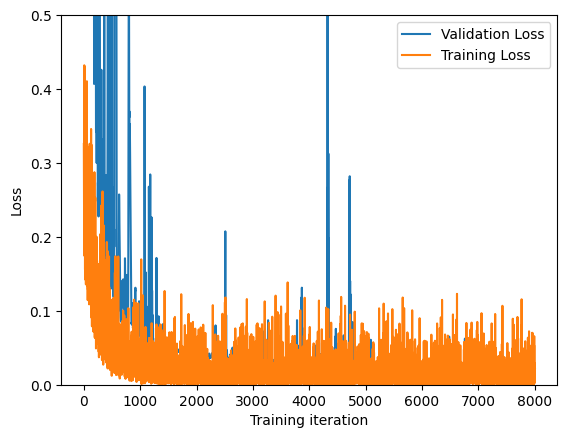

In [49]:
# Training model
for epoch in range(n_epochs):
    batch_index = torch.randperm(np.shape(training_data)[0])[batch_size]
    loss_save = vae.training_step(training_data[batch_index], test_data, beta=beta)
    loss_dico['training'].append(loss_save[0])
    loss_dico['validation'].append(loss_save[1])
plt.plot(range(len(loss_dico['validation'])), loss_dico['validation'], label = 'Validation Loss')
plt.plot(range(len(loss_dico['training'])), loss_dico['training'], label = 'Training Loss')
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.ylim([0,0.5])
plt.legend()
plt.show()

(3, 156)


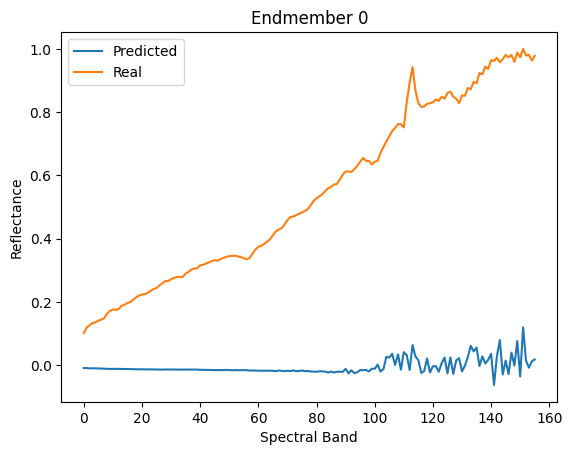

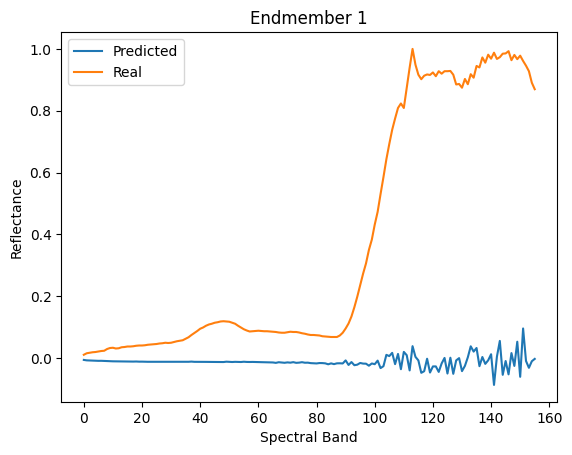

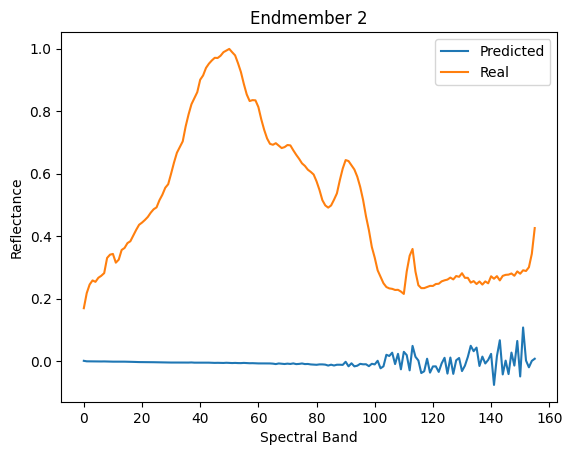

In [50]:
# Plot the predicted spectrum and the real spectrum of endmembers
predicted_endmembers_curves = (vae.decoder.weight.T).detach().numpy()
print(predicted_endmembers_curves.shape)
endmembers_curves = E
n_sources = endmembers_curves.shape[0]


for source in range(n_sources):
    plt.plot(predicted_endmembers_curves[source], label='Predicted')
    plt.plot(endmembers_curves[source], label='Real')
    plt.title(f"Endmember {source}")
    plt.xlabel("Spectral Band")
    plt.ylabel("Reflectance")
    plt.legend()
    plt.show()

